# Sberbank Russian Housing Market
Charlie Bonfield <br/>
Created: May 2017

*Insert description of the notebook here.* 

## Load/Examine the Data

In [1]:
# Import statements 
import numpy as np 
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from boruta import BorutaPy as bp
from sklearn import model_selection, preprocessing
from sklearn.ensemble import RandomForestRegressor as rfr

%matplotlib inline

#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=12, usetex=True)

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
macro_data = pd.read_csv('macro.csv')

# Print shapes of training, test, and macro dataframes.
print('Training: ') 
print(train_data.shape)
print('Test: ')
print(test_data.shape)
print('Macro: ')
print(macro_data.shape)

# Examine data
train_data.head()

Training: 
(30471, 292)
Test: 
(7662, 291)
Macro: 
(2484, 100)


,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [3]:
# Split off columns that will be needed later. 
train_ids = train_data['id'].values
test_ids = test_data['id'].values
train_prices = train_data['price_doc'].values
train_lprices = np.log1p(train_prices)

train_data.drop(['id', 'price_doc'], axis=1, inplace=True)
test_data.drop(['id'], axis=1, inplace=True)

# Merge macro.csv to training/test data. 
n_train = len(train_data.index)
all_tt_data = pd.concat([train_data, test_data])
all_data = pd.merge_ordered(all_tt_data, macro_data, on='timestamp', how='left')
#print(all_data.shape)

# Fix a couple of values (based on another's work - cited below). 
# https://www.kaggle.com/captcalculator/a-very-extensive-sberbank-exploratory-analysis

# state should be discrete valued between 1 and 4. There is a 33 in it that is cleary a data entry error
# Lets just replace it with the mode.
#dtrain$state[dtrain$state == 33] <- which.max(table(dtrain$state))

# build_year has an erronus value 20052009. Since its unclear which it should be, let's replace with 2007
#dtrain$build_year[dtrain$build_year == 20052009] <- 2007

Let's look for missing data!

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117]),
 <a list of 118 Text xticklabel objects>)

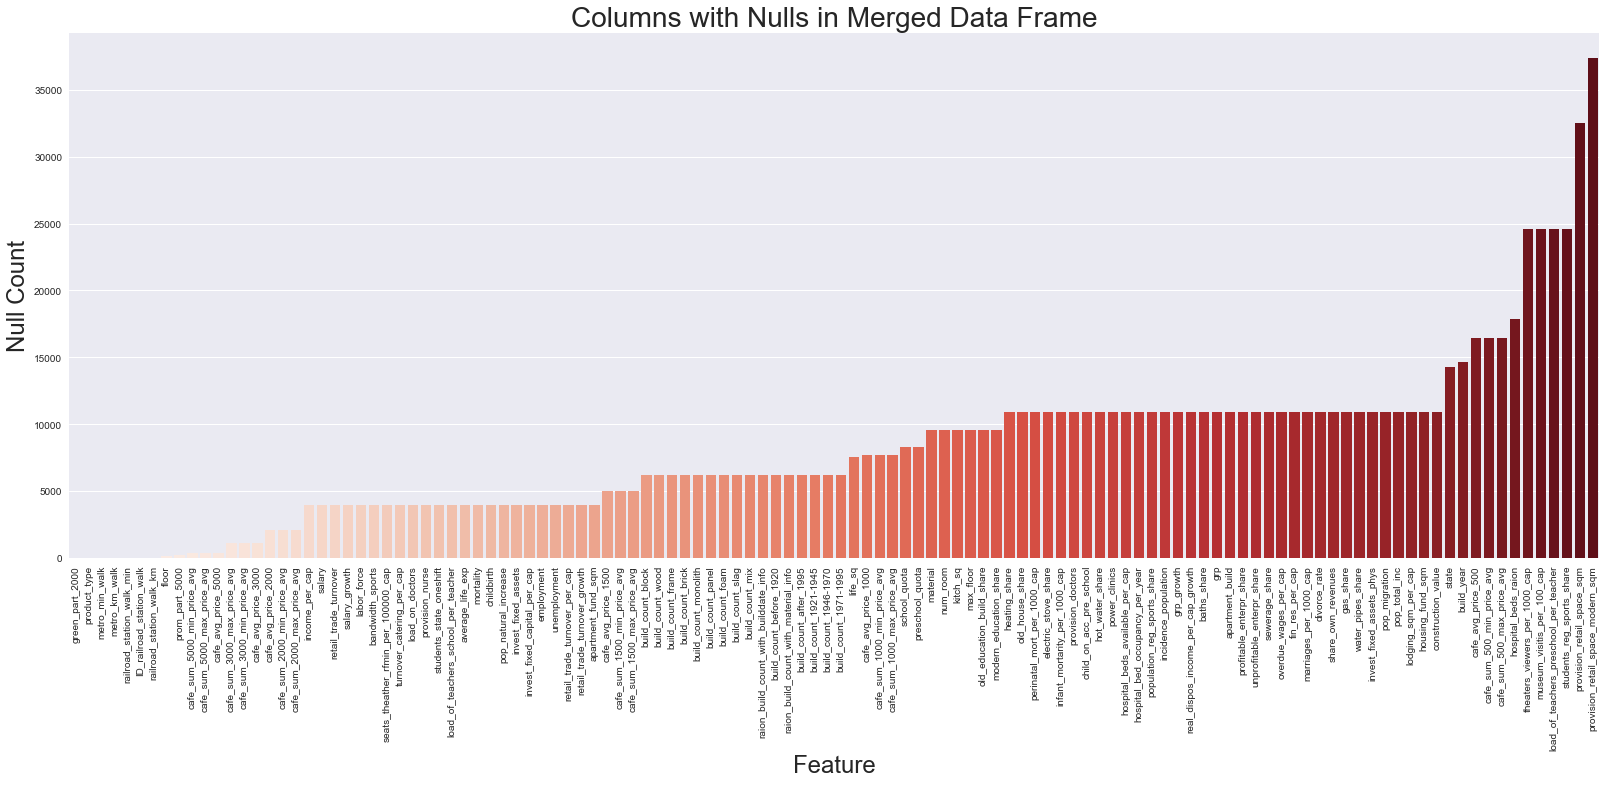

In [4]:
# Check data for missing values, return counts for columns with missing data. 
# Code taken from: https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-sberbank
#
null_counts = all_data.isnull().sum(axis=0).reset_index()
null_counts.columns = ['Feature', 'Count']
missing_cols = null_counts.loc[null_counts['Count'] > 0]
missing_cols = missing_cols.sort_values(by='Count')

# Plot null counts for features.
fig = plt.figure(figsize=(25, 10))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

ax = fig.add_subplot(111)
sns.barplot(x=missing_cols['Feature'], y=missing_cols['Count'], palette='Reds')
ax.set_xlabel('Feature', fontsize=24)
ax.set_ylabel('Null Count', fontsize=24)
ax.set_title('Columns with Nulls in Merged Data Frame', fontsize=28)
plt.xticks(rotation=90)
#ax.set_title('Comparison of Individual Dispersions', fontsize=26)
#ax.tick_params(axis='x',labelsize=24)
#ax.tick_params(axis='y',labelsize=24)

Given the large number of features with missing data, let's check where they're coming from. After reviewing the axis labels displayed above, I suspect many of them are coming from the macro data. (In retrospect, I probably should have checked this before merging the macro data with the training/test data.)

In [5]:
# Check how many of the nulls actually come from the macro data (same code as above). 
macro_null_counts = macro_data.isnull().sum(axis=0).reset_index()
macro_null_counts.columns = ['Feature', 'Count']
macro_missing_cols = macro_null_counts.loc[macro_null_counts['Count'] > 0]
macro_missing_cols = macro_missing_cols.sort_values(by='Count')

print('Number of features with nulls in macro: %f' % len(macro_missing_cols.index))
print('Number of features with nulls in training/test: %f' % (len(missing_cols.index) - len(macro_missing_cols.index)))

# Plot null counts for features.
#fig = plt.figure(figsize=(25, 10))
#fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

#ax = fig.add_subplot(111)
#sns.barplot(x=macro_missing_cols['Feature'], y=macro_missing_cols['Count'], palette='Reds')
#ax.set_xlabel('Feature', fontsize=24)
#ax.set_ylabel('Null Count', fontsize=24)
#ax.set_title('Columns with Nulls in Macro Data Frame', fontsize=28)
#plt.xticks(rotation=90)
#ax.set_title('Comparison of Individual Dispersions', fontsize=26)
#ax.tick_params(axis='x',labelsize=24)
#ax.tick_params(axis='y',labelsize=24)

Number of features with nulls in macro: 91.000000
Number of features with nulls in training/test: 27.000000


Insert discussion about how xgboost handles missing data. 

## Feature Engineering

### I. Extracting Information from Timestamps 

In [6]:
# Extract year, month, day of week, and week of year.
# Taken from: https://www.kaggle.com/bguberfain/naive-xgb-lb-0-317
years = pd.to_datetime(all_data.timestamp, errors='coerce').dt.year
months = pd.to_datetime(all_data.timestamp, errors='coerce').dt.month
dows = pd.to_datetime(all_data.timestamp, errors='coerce').dt.dayofweek
woys = pd.to_datetime(all_data.timestamp, errors='coerce').dt.weekofyear
doys = pd.to_datetime(all_data.timestamp, errors='coerce').dt.dayofyear

# Extract number of sales in month/year combos, week/year combos. 
# Taken from: https://www.kaggle.com/bguberfain/naive-xgb-lb-0-317
month_year = (months + years * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
week_year = (woys + years * 100)
week_year_cnt_map = week_year.value_counts().to_dict()

# Add all new features to existing data frame. 
all_data['year'] = years
all_data['month'] = months
#all_data['day_of_week'] = dows      # do not see fluctuations on this scale (see below).
#all_data['day_of_year'] = doys      # do not see fluctuations on this scale (see below).
all_data['month_year_count'] = month_year.map(month_year_cnt_map)
all_data['week_year_count'] = week_year.map(week_year_cnt_map)

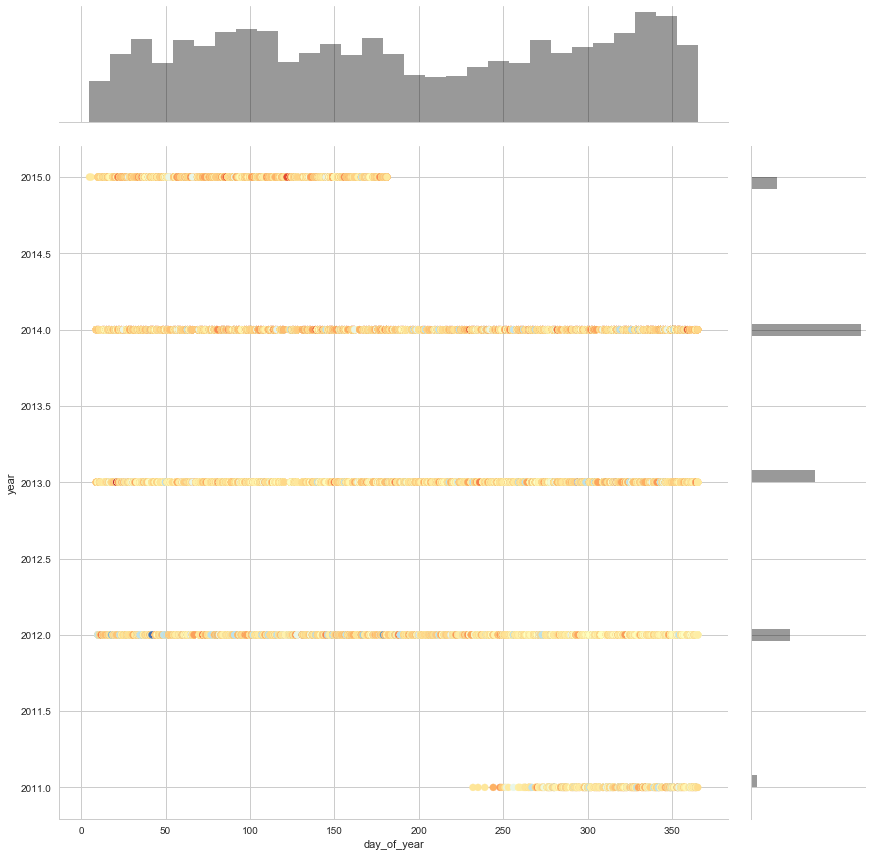

In [7]:
# Examine how price varies as a function of month/year for training set
# to see if we expect there to be any trends on more finer scales.
v1 = years.values
v2 = doys.values
train_years = v1[:n_train].astype(int) 
train_doys = v2[:n_train].astype(int)
train_dates = pd.DataFrame({'year':train_years,'day_of_year':train_doys}) 

sns.set_style('whitegrid', {'image.cmap': u'RdYlBu'})
g = sns.JointGrid(x='day_of_year', y='year', data=train_dates, size=12)
g = g.plot_joint(plt.scatter, c=np.max(train_lprices)-train_lprices, edgecolor='face')
g = g.plot_marginals(sns.distplot, kde=False, color='0.0')

In [8]:
# Drop timestamps. 
all_data.drop(['timestamp'], axis=1, inplace=True)

### II. Property-Specific Features

In [9]:
# Deal with categorical values. 
# Taken from: https://www.kaggle.com/bguberfain/naive-xgb-lb-0-317
df_numeric = all_data.select_dtypes(exclude=['object'])
df_obj = all_data.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

all_values = pd.concat([df_numeric, df_obj], axis=1)

# Fill all NaNs with -99 (hacky fix to allow Boruta to do it's thing).
all_values = all_values.fillna(value=-99)

In [10]:
# After feature engineering has been completed, split data back into training/test sets. 
# Taken (with modifications) from: https://www.kaggle.com/bguberfain/naive-xgb-lb-0-317
x_all = all_values.values

# Create a validation set with last 20% of training data.
n_val = int(n_train * 0.2)

x_train_all = x_all[:n_train]
x_train_sub = x_all[:n_train-n_val]
x_train_val = x_all[n_train-n_val:n_train]
y_train_all = train_lprices.ravel()      # Log(price)
y_train_sub = y_train_all[:-n_val]       # Log(price)
y_train_val = y_train_all[-n_val:]       # Log(price)

x_test = x_all[n_train:]

# Check to make sure that everything is the correct size.
print('Training Data (x_all): ', x_train_all.shape)
print('Training Data (x_sub): ', x_train_sub.shape)
print('Training Data (y_sub): ', y_train_sub.shape)
print('Training Data (x_val): ', x_train_val.shape)
print('Training Data (y_val): ', y_train_val.shape)
print('Test Data (x): ', x_test.shape)

Training Data (x_all):  (30471, 392)
Training Data (x_sub):  (24377, 392)
Training Data (y_sub):  (24377,)
Training Data (x_val):  (6094, 392)
Training Data (y_val):  (6094,)
Test Data (x):  (7662, 392)


## Feature Selection (BorutaPy)

In [ ]:
# Define random forest regressor, utilising single core and sampling in proportion to y labels.
# To utilize all cores, set n_jobs = -1. 
random_forest = rfr(n_jobs=3, criterion='mse', max_depth=None, max_features=None)

# Define the Boruta feature selection method. 
feature_selector = bp(random_forest, n_estimators='auto', verbose=2, random_state=1)

# Find all relevant features. 
feature_selector.fit(x_train_all, y_train_all)

# Check selected features.
feature_selector.support_

# Check ranking of features.
feature_selector.ranking_

# call transform() on X to filter it down to selected features
#X_filtered = feat_selector.transform(X)